In [18]:
# imports

import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})

In [19]:
# get current working directory
cwd = os.getcwd()

df = pd.read_csv(cwd + "/filtered_customer_booking.csv", index_col=0)

In [20]:

df = df.reset_index(drop=True)

In [21]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [22]:
df.shape

(49982, 14)

In [23]:
df_final = df

In [24]:
#we need to apply One hot encoding to categorical values
from sklearn.preprocessing import OneHotEncoder


#create instance of one hot encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#one hot encode Sales Channel
encoder_df = pd.DataFrame(encoder.fit_transform(df[["sales_channel"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'Internet', 1:'Mobile'})
df_final = df_final.join(encoder_df)

#one hot encode trip type
encoder_df = pd.DataFrame(encoder.fit_transform(df[["trip_type"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'RoundTRip', 1:'OneWayTrip',2:'CircleTrip'})
df_final = df_final.join(encoder_df)

In [25]:
df_final.booking_origin.nunique()

104

In [26]:
#drop categorical columns now
df_final.drop(['sales_channel', 'trip_type','booking_origin', 'route'], axis=1, inplace = True)

In [27]:
#store the label for supervised learning
label = df['booking_complete']

In [28]:
df_final = df_final.drop('booking_complete', axis=1)

In [29]:
df_final.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip
0,2,262,19,7,6,1,0,0,5.52,1.0,0.0,0.0,0.0,1.0
1,1,112,20,3,6,0,0,0,5.52,1.0,0.0,0.0,0.0,1.0
2,2,243,22,17,3,1,1,0,5.52,1.0,0.0,0.0,0.0,1.0
3,1,96,31,4,6,0,0,1,5.52,1.0,0.0,0.0,0.0,1.0
4,2,68,22,15,3,1,0,1,5.52,1.0,0.0,0.0,0.0,1.0


In [30]:
df_final.shape

(49982, 14)

Normalizaing the values

In [31]:
from sklearn.preprocessing import StandardScaler

#create a standard scaler object
scaler = StandardScaler()

#fit and transform the data
scaled_df = scaler.fit_transform(df_final)

In [32]:
#create a dataframe of scaled data
scaled_df = pd.DataFrame(scaled_df, columns = df_final.columns)

In [33]:
# add the labels back to the dataframe
scaled_df['label']  = label

In [34]:
scaled_df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip,label
0,0.400769,1.971093,-0.119401,-0.381588,1.096876,0.703587,-0.650054,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
1,-0.579424,0.302987,-0.089895,-1.120618,1.096876,-1.421288,-0.650054,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
2,0.400769,1.759799,-0.030885,1.465988,-0.408618,0.703587,1.538334,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
3,-0.579424,0.125056,0.234662,-0.935861,1.096876,-1.421288,-0.650054,1.158002,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
4,0.400769,-0.186323,-0.030885,1.096473,-0.408618,0.703587,-0.650054,1.158002,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0


Correlation matrix

<AxesSubplot:>

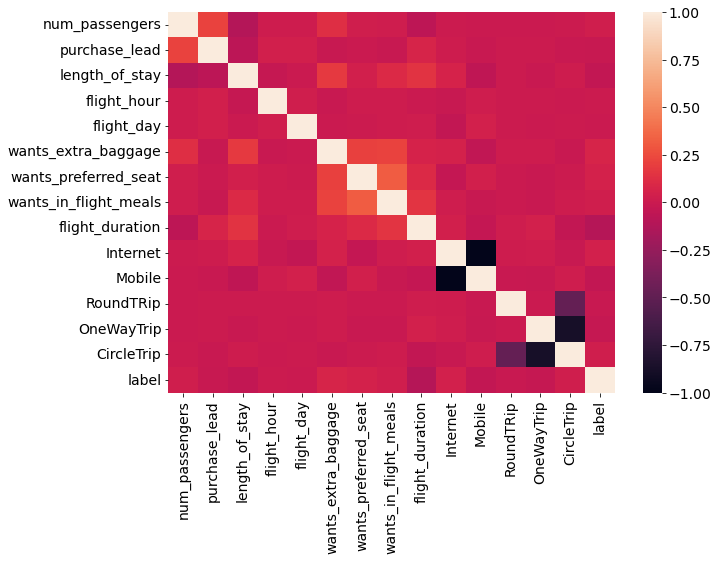

In [35]:
corr = scaled_df.corr()

plt.figure(figsize=(10,7))

#plot the heatmap
sns.heatmap(corr)

Splitting Train and Test Data

In [36]:
from sklearn.model_selection import train_test_split

X = scaled_df.iloc[:,:-1]
y = scaled_df['label']

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.inspection import permutation_importance

from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV,  RepeatedStratifiedKFold

In [38]:
"""
    Create functions to fit and predict the values of whether customer would complete the booking.
    Also functions with metrics to evaluate the model prediction.

"""

def model_fit_predict(model, X, y, X_predict):
    model.fit(X, y)
    return model.predict(X_predict)

def acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def pre_score(y_true, y_pred):
    return precision_score(y_true, y_pred)

def f_score(y_true, y_pred):
    return f1_score(y_true, y_pred)

Random Forest Classifier

In [39]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

Checking Training accuracy

In [40]:
y_pred_train = model_fit_predict(clf_rf, X_train, y_train, X_train)
set(y_pred_train)

#f1 score for training data
f1 = round(f1_score(y_train, y_pred_train),2) 

#accuracy score for training data
acc = round(accuracy_score(y_train, y_pred_train),2) 

#precision score for training data
pre = round(precision_score(y_train, y_pred_train),2) 

print(f"Accuracy is {acc}, Precision is {pre} and f1-score is {f1} for training data")

Accuracy is 0.93, Precision is 1.0 and f1-score is 0.72 for training data


0.9341002876078529

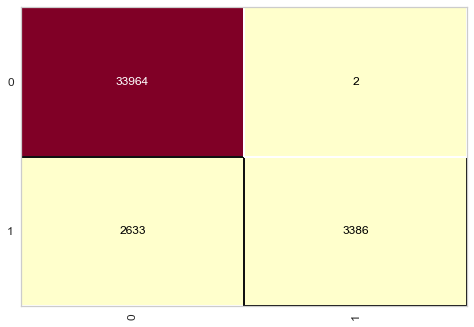

In [41]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_train, y_train)

Checking Testing accuracy

In [57]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

#f1 score for training data
f1 = round(f1_score(y_test, y_pred_test),2) 

#accuracy score for training data
acc = round(accuracy_score(y_test, y_pred_test),2) 

#precision score for training data
pre = round(precision_score(y_test, y_pred_test),2) 

recall = round(recall_score(y_test, y_pred_test),2)

print(f"Accuracy is {acc}, Precision is {pre} , Recall is {recall}, and f1-score is {f1} for testing data")

Accuracy is 0.63, Precision is 0.61 , Recall is 0.59, and f1-score is 0.6 for testing data


0.8554566369910973

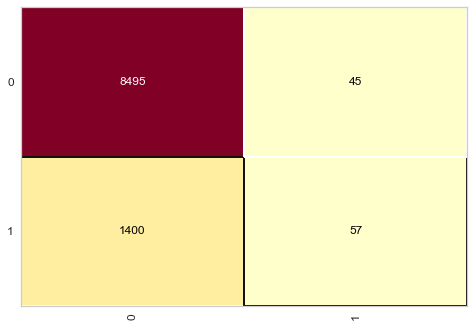

In [43]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_test, y_test)

Text(0.5, 0, 'Random Forest Feature Importance')

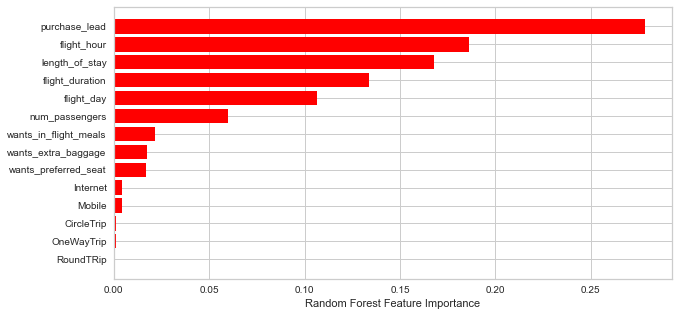

In [44]:
plt.figure(figsize=(10, 5))
sorted_idx = clf_rf.feature_importances_.argsort()

# Define the color for the bars
bar_color = 'red'  # Change this to any valid Matplotlib color, e.g., 'red', '#FF5733', etc.

plt.barh(scaled_df.iloc[:, :-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx], color=bar_color)
plt.xlabel("Random Forest Feature Importance")


One major problem behind getting low F1 score is imbalanced dataset. We have higher entries that are classified 0 than 1. We could reduce the number of entries that are classified 0 to be equal around the number of entries that are classified as 1.

Balancing the dataset

In [45]:
scaled_df.label.value_counts()

0    42506
1     7476
Name: label, dtype: int64

In [46]:
#create a dataframe having all labels 0 with 10000 samples
scaled_df_0 = scaled_df[scaled_df.label ==0].sample(n=8000)

In [47]:
#concatenate the two dataframee, one havng all labels 0 and other having all labels as 1
scaled_df_new = pd.concat([scaled_df[scaled_df.label==1], scaled_df_0], ignore_index=True)

In [48]:
#shuffle the dataframe rows
scaled_df_new = scaled_df_new.sample(frac = 1).reset_index(drop=True)

In [49]:
scaled_df_new

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip,label
0,0.400769,-0.631152,-0.561979,-1.674891,0.093214,0.703587,-0.650054,1.158002,-0.439155,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
1,0.400769,0.169539,-0.502969,-0.012073,0.093214,-1.421288,-0.650054,-0.863557,-0.439155,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
2,0.400769,-0.230806,-0.178411,0.357443,-0.408618,0.703587,1.538334,-0.863557,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
3,0.400769,-0.030634,-0.561979,-0.012073,0.595045,0.703587,-0.650054,-0.863557,-0.439155,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
4,-0.579424,-0.664514,-0.591484,-0.935861,-1.412280,-1.421288,-0.650054,-0.863557,-0.439155,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15471,-0.579424,-0.920290,-0.119401,-0.196830,-0.408618,0.703587,-0.650054,-0.863557,0.195526,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
15472,-0.579424,0.280746,-0.178411,-0.935861,1.096876,-1.421288,-0.650054,1.158002,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
15473,2.361155,-0.486582,-0.001380,0.726958,-0.408618,0.703587,1.538334,1.158002,1.037314,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
15474,-0.579424,-0.931411,-0.561979,-1.305376,0.093214,-1.421288,-0.650054,-0.863557,-0.439155,-2.810681,2.810681,-0.048231,-0.088336,0.100826,1


In [50]:
X = scaled_df_new.iloc[:,:-1]
y = scaled_df_new['label']

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

In [51]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(n_estimators=50,max_depth =50 , min_samples_split=5,random_state=0)

In [60]:
y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

#f1 score for training data
f1 = round(f1_score(y_test, y_pred_test),2) 

#accuracy score for training data
acc = round(accuracy_score(y_test, y_pred_test),2) 

#precision score for training data
pre = round(precision_score(y_test, y_pred_test),2) 

specificity = round(recall_score(y_test, y_pred_test, pos_label=0),2)

recall = round(recall_score(y_test, y_pred_test),2)

print(f"Accuracy is {acc}, Precision is {pre} , Recall is {recall}, and f1-score is {f1} for testing data")

Accuracy is 0.63, Precision is 0.61 , Recall is 0.59, and f1-score is 0.6 for testing data


0.6304909560723514

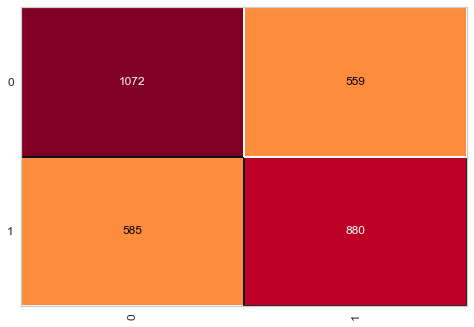

In [54]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_test, y_test)

Text(0.5, 0, 'Random Forest Feature Importance')

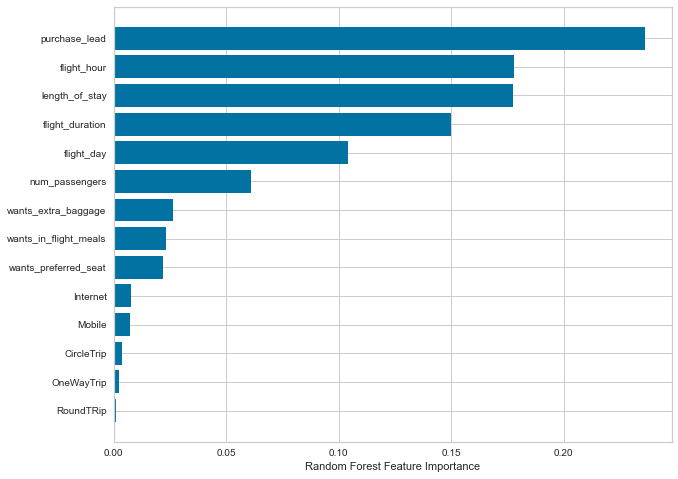

In [55]:
plt.figure(figsize=(10,8))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(scaled_df.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")